Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 3: k-Nearest Neighbors & Logistic Regression

Jérémie DECOCK - Adrien EHRHARDT

## Objectives

- Implement Logistic Regression and *(k)-Nearest Neighbor(s)*
- Use it to solve classification and regression problems
- Define the decision boundaries
- Explain the weaknesses of these algorithms

## Imports and tool functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import sklearn.neighbors
from sklearn.utils import shuffle
from scipy.spatial import Voronoi, voronoi_plot_2d

In [3]:
def gen_2d_classification_samples(n_samples: int = 20, nclass: int = 3) -> pd.DataFrame:
    """
    Generates 2-dimensional samples which belong to either 2 or 3 classes

    :param int n_samples: number of samples to draw per class
    :param int nclass: number of classes the samples belong to (either 2 or 3)
    :returns: dataframe containing X (2 coordinates x1, x2) and y (as int!)
    """
    cov = np.diag([2., 2.])

    x1 = np.random.multivariate_normal(mean=[0., 0.], cov=cov, size=n_samples)
    y1 = np.full(n_samples, 1, dtype=int)

    x2 = np.random.multivariate_normal(mean=[4., 0.], cov=2.5*cov, size=n_samples)
    y2 = np.full(n_samples, 2, dtype=int)

    x3 = np.random.multivariate_normal(mean=[2., 4.], cov=cov, size=3*n_samples)
    y3 = np.full(3*n_samples, 3, dtype=int)

    if nclass == 3:
        X = np.concatenate([x1, x2, x3])
        y = np.concatenate([y1, y2, y3])
    elif nclass == 2:
        X = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
    else:
        raise ValueError("Only 2 or 3 classes")

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

In [37]:
def gen_and_plot_1d_regression_samples(n_samples : int = 40):
    """
    Generates 1-dimensional regression samples

    :param int n_samples: number of samples to draw
    :returns: dataframe containing X (1 coordinate x) and y
    """
    x = np.random.uniform(low=-10., high=10., size=n_samples)
    # This is y = 2x + 3 + epsilon, similar to lab_session_02
    y = -2. * x + 1. + np.random.normal(scale=4., size=x.shape)

    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df.plot.scatter(x='x', y='y');
    return df

In [36]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_2d_classification_samples(dataframe: pd.DataFrame, model=None,
                                   voronoi: bool = False):
    """
    Plots the 2D classification problem, possibly with the results of a given model and the Voronoi cells.
    """
    plt.figure(figsize=(8, 8))
    df = dataframe  # make an alias so as not to modify dataframe
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x1', 'x2', 'y']"
    assert df.columns.values.tolist() == ['x1', 'x2', 'y'], ERROR_MSG1
    
    ERROR_MSG2 = "The `dataframe` parameter should be a Pandas DataFrame having the following labels (in column 'y'): [1, 2, 3]"
    labels = pd.unique(df.y).tolist()
    labels.sort()
    assert labels == [1, 2, 3] or labels == [1, 3] or labels == [1, 2], ERROR_MSG2

    if model is not None:
        if voronoi:
            # Compute the Voronoi cells            
            vor = Voronoi(df[['x1', 'x2']])

            # Plot the Voronoi diagram
            fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False);
            fig.set_size_inches(8, 8);
        
        # Compute the model's decision boundaries
        h = .02  # step size in the mesh
        x_min, x_max = df.x1.min() - 1, df.x1.max() + 1
        y_min, y_max = df.x2.min() - 1, df.x2.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the model's decision boundaries
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5, shading="auto")

    # Plot also the training points
    plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)

## Logistic Regression (Gradient Descent)

$k$-NN is a **non-parametric**, **classification** (with arbitrary number of classes) and **regression** algorithm.

Logistic regression is a **parametric binary classification algorithm**, so we generate a dataframe `df` containing a label `y` with only 2 classes (`0` and `1`).

In [5]:
df = gen_2d_classification_samples(n_samples = 100, nclass = 2)

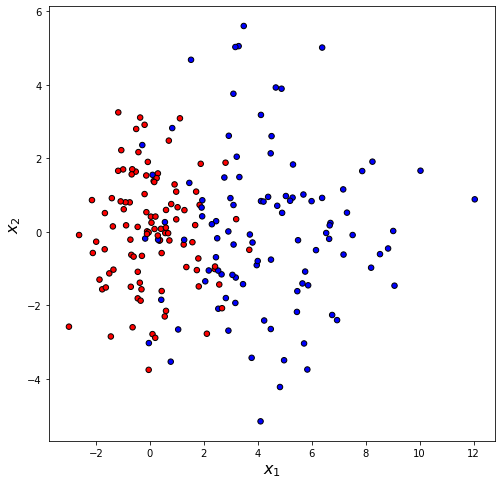

In [6]:
plot_2d_classification_samples(df)

In [7]:
X = np.array([np.ones((df.shape[0])), df.x1, df.x2])
y = np.array(df.y) - 1

Logistic regression is very similar to linear regression in so far as it is a **parametric model** which aims at finding a parameter $\boldsymbol{\theta}^\star$ such as $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ provides a good "link" between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \{0,1\}$ in a *learning set* $\mathcal{D} = \{(\boldsymbol{x}^{(i)}, y^{(i)})\}_{1 \leq i \leq n}$ of $n$ examples:

$$
\boldsymbol{\theta}^\star = \arg\!\min E(\boldsymbol{\theta}, \mathcal{D}),
$$

where $E(\boldsymbol{\theta}, \mathcal{D}) = - \sum_{i=1}^n \ln p_{\boldsymbol{\theta}}(y^{(i)} | \boldsymbol{x}^{(i)})$.

This is called the log loss (machine learning community), or the negative loglikelihood (statistics community).

Fortunately, logistic regression is a rather simple model which states:

$$
p_{\boldsymbol{\theta}}(1 | \boldsymbol{x}^{(i)}) = \frac{1}{1+\exp{(-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)})}}
$$

The loss function $E(\boldsymbol{\theta}, \mathcal{D})$ is convex, which means $\boldsymbol{\theta}^\star$ exists, is unique, and can be obtained by minimizing $E$.

### Exercise 1

Complete the following `gradient_descent` function implemented in the last lab to work for logistic regression. 

**Hint**: only the gradient needs to be changed.

In [107]:
def gradient_descent(X, y, eta=0.001, max_iteration=10000, initial_theta=None):

    if initial_theta is None:
        # The initial solution is selected randomly
        theta = np.random.normal(loc=0, scale=10, size=[3, 1])
    else:
        theta = initial_theta


    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    grad_list = []      # Keep the gradient of all iterations
    theta_list = []     # Keep the solution of all iterations
    # Perform useful matrix multiplication
    def give_grad(sigma):
        sigma = sigmoid(theta.T.dot(X))
        return X.dot((sigma-y).T)

    for i in range(max_iteration):
        # Perform the gradient descent here
        # Perform the gradient descent here
        grad = give_grad(theta)
       # grad_list.append([grad[0][0], grad[1][0]])      # Keep the gradient
       # theta_list.append([theta[0][0], theta[1][0]])   # Keep the solution
        grad_list.append(grad)      # Keep the gradient
        theta_list.append(theta)   # Keep the solution

        theta = theta - eta*grad

    return grad_list, theta_list

(You don't have to fill in anything in the following cell; it's a general comment about the solution of the previous cell which will be provided in the solutions of this lab session.)

In [108]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

theta = np.random.normal(loc=0, scale=10, size=[3, 1])
print(sigmoid(theta.T.dot(X)).shape)
print(X.shape)
print(y.shape)

(1, 200)
(3, 200)
(200,)


YOUR ANSWER HERE

In [109]:
grad_list, theta_list = gradient_descent(X, y, eta = 0.001)

Let's see if it has converged by plotting the parameters w.r.t. the iteration number:

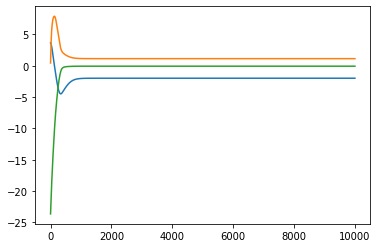

In [110]:
plt.plot([theta[0] for theta in theta_list]);
plt.plot([theta[1] for theta in theta_list]);
plt.plot([theta[2] for theta in theta_list]);

Let's see the decision boundary, i.e. the half-spaces where each label is predicted.

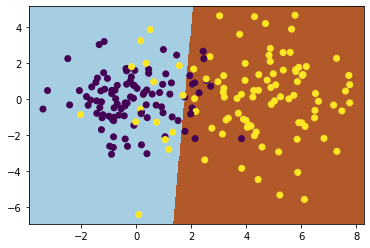

In [111]:
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = 1 / (1 + np.exp(-np.dot(np.c_[np.ones((len(xx.ravel()))),
                                  xx.ravel(), yy.ravel()], theta_list[9999])))
plt.pcolormesh(xx, yy, (Z.reshape(xx.shape) > 0.5)*1, cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=y);

## Logistic Regression (scikit-learn)

### Exercise 2

Let's do the same using scikit-learn!

Similar to the previous lab, logistic regression belongs to the linear model module, and provides among others the `fit` and `predict` methods. Use the `fit` method to compare the coefficients obtained with scikit-learn and your gradient descent.

**Beware of the `C` parameter**, which corresponds to L2 regularization (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) - this will be the subject of subsequent lectures; set it to an arbitrarily high value, e.g. `1e9`.

In [112]:
# Uncomment and provide the appropriate parameters:
model = sklearn.linear_model.LogisticRegression(C=1e9, fit_intercept=False)
model.fit(X.T, y)

LogisticRegression(C=1000000000.0, fit_intercept=False)

Let's see if we came up with the same estimates:

In [113]:
print("Intercept")
print("=========")
print("sklearn:\t\t", model.coef_[0][0])
print("gradient descent: \t", theta_list[9999][0])
print("\n")

print("theta_1")
print("=========")
print("sklearn:\t\t", model.coef_[0][1])
print("gradient descent:\t", theta_list[9999][1])
print("\n")

print("theta_2")
print("=========")
print("sklearn:\t\t", model.coef_[0][2])
print("gradient descent:\t", theta_list[9999][2])

Intercept
sklearn:		 -1.9886561589491873
gradient descent: 	 [-1.98865636]


theta_1
sklearn:		 1.1333618646098274
gradient descent:	 [1.13336262]


theta_2
sklearn:		 -0.06822215181734548
gradient descent:	 [-0.0682238]


## Logistic Regression with Polynomial Basis Functions

We will now generate some data with a non-linear boundary between classes to illustrate the power of the logistic regression classifier with polynomial basis function features as input. 

In [123]:
def gen_nonlinear_2d_classification_samples(n_samples: int = 20, nclass: int = 3) -> pd.DataFrame:
    """
    Generates 2-dimensional samples which belong to either 2 or 3 classes

    :param int n_samples: number of samples to draw per class
    :param int nclass: number of classes the samples belong to (either 2 or 3)
    :returns: dataframe containing X (2 coordinates x1, x2) and y (as int!)
    """
    cov1 = np.diag([2., 2])
    cov2 = np.diag([6., 2])

    x1 = np.random.multivariate_normal(mean=[-3., 0.], cov=cov1, size=n_samples)
    y1 = np.full(n_samples, 1, dtype=int)
    x2 = np.random.multivariate_normal(mean=[3., 6], cov=cov1, size=n_samples)
    y2 = np.full(n_samples, 1, dtype=int)
    x3 = np.random.multivariate_normal(mean=[3., -6.], cov=cov1, size=n_samples)
    y3 = np.full(n_samples, 1, dtype=int)

    x4 = np.random.multivariate_normal(mean=[3., 0.], cov=cov2, size=n_samples)
    y4 = np.full(n_samples, 2, dtype=int)

    if nclass == 2:
        X = np.concatenate([x1, x2, x3, x4])
        y = np.concatenate([y1, y2, y3, y4])
    else:
        raise ValueError("Only 2 or 3 classes")

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

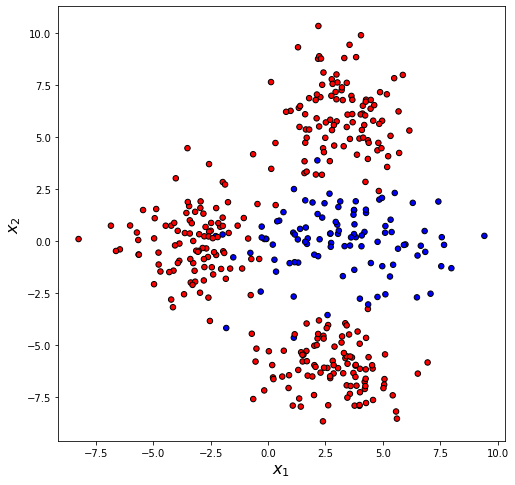

In [124]:
df = gen_nonlinear_2d_classification_samples(n_samples=100, nclass=2)
plot_2d_classification_samples(df)

### Exercise 3

Please fit two logisic regression models. The first model called `model_lin` should be fit to the data stored in `df`. While the second model called `model_sq` should be fit to a dataframe containing also entries corresponding to the squared values of the $x_1$ and $x_2$ features, i.e., this second model should have 5 parameters. 

Then, use the two models to predict the class of the point $\begin{pmatrix}{3 \\ 0}\end{pmatrix}$ and store the predictions of `model_lin` and `model_sq` in `pred_lin` and `pred_sq`, respectively.

In [44]:
print(df)

           x1        x2  y
0    4.016028  8.378818  1
1    2.899711  7.533662  1
2    1.217806  2.172498  2
3    3.303509 -5.526899  1
4    2.300093  1.411879  2
..        ...       ... ..
395 -1.313537 -1.088562  1
396  0.347062 -4.340810  1
397  4.213402 -6.050423  1
398  1.493923  6.375813  1
399  4.778327  6.009736  1

[400 rows x 3 columns]


In [126]:
# Extract features (X) and target variable (y)
X = df[['x1', 'x2']]
y = df['y']

# Fit linear model
model_lin = sklearn.linear_model.LogisticRegression(C=1e9)
model_lin.fit(X, y)

# Fit quadratic model
X_sq = np.column_stack((X, X ** 2))
model_sq = sklearn.linear_model.LogisticRegression(C=1e9)
model_sq.fit(X_sq, y)

# Make predictions for point (3, 0)
point = np.array([[3, 0]])
point_sq = np.column_stack((point, point ** 2))
pred_lin = model_lin.predict(point)
pred_sq = model_sq.predict(point_sq)

print('Prediction using linear model:', pred_lin)
print('Prediction using quadratic model:', pred_sq)

Prediction using linear model: [1]
Prediction using quadratic model: [2]


/home/erikdz/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Run the below code cell to visualise the decision boundaries of `model_lin` and `model_sq`.

/home/erikdz/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


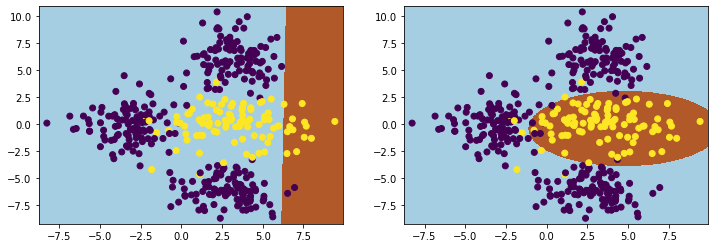

In [127]:
plt.figure(figsize=(12, 4))

# model_lin
plt.subplot(1, 2, 1)
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.pcolormesh(xx, yy, model_lin.predict(np.concatenate([
    xx.ravel().reshape((-1,1)),yy.ravel().reshape((-1,1))], axis=1)).reshape(xx.shape),
               cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=df['y']);

# model_sq
plt.subplot(1, 2, 2)
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.pcolormesh(xx, yy, model_sq.predict(np.concatenate([
    xx.ravel().reshape((-1, 1)),yy.ravel().reshape((-1, 1)),
    xx.ravel().reshape((-1, 1))**2, yy.ravel().reshape((-1, 1))**2],
    axis=1)).reshape(xx.shape), cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=df['y']);

## Nearest Neighbor algorithm

Here you will implement one of the simplest (but quite powerful) machine learning algorithm: the *Nearest Neighbor* algorithm and its extension the *k-Nearest Neighbors* algorithm (or *kNN*). Both can be used for classification and regression tasks.

Considering a dataset $\mathcal{D}=\{(\boldsymbol{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples, the *Nearest Neighbor* model assigns an input vector $\boldsymbol{x}$ (of dimension $p$) to the label $y_{{\arg\!\min}_{i=1,\dots, n}d(x, x_i)}$ of its closest neighbor in $\mathcal{D}$.

The closest neighbor is defined w.r.t. a distance function $d$. This can be any metric measure, but the *Minkowski distance* (especially the classical Euclidian distance $d_2$) is the most common choice. It is defined as follows:

$$d_q: \mathbb{R}^p \times \mathbb{R}^p \to \mathbb{R}$$

$$d_q(\boldsymbol{u}, \boldsymbol{v}) = ||\boldsymbol{u} - \boldsymbol{v}||_q = \left( \sum_{j=1}^p |u_j - v_j|^q \right)^{1/q}$$

When $q=2$, $d_q$ is the *Euclidian distance*

$$d_2(\boldsymbol{u}, \boldsymbol{v}) = \sqrt{\sum_{j=1}^{p} (u_j - v_j)^2}$$

When $q=1$, $d_q$ is the *Manhattan distance*

$$d_1(\boldsymbol{u}, \boldsymbol{v}) = \sum_{j=1}^{p} |u_j - v_j|$$

When $q=\infty$, $d_q$ is the  *Tchebychev distance*

$$d_{\infty}(\boldsymbol{u}, \boldsymbol{v}) = \max_{j=1,\dots,p} |u_j - v_j|$$

### Exercise 4

We consider the following dataset (where `x1` and `x2` are examples' features and where `y` represents the examples' labels):

In [128]:
data = [[0, 0, 1],
        [0, 1, 1],
        [1, 1, 2],
        [1, 0, 3]]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,0,0,1
1,0,1,1
2,1,1,2
3,1,0,3


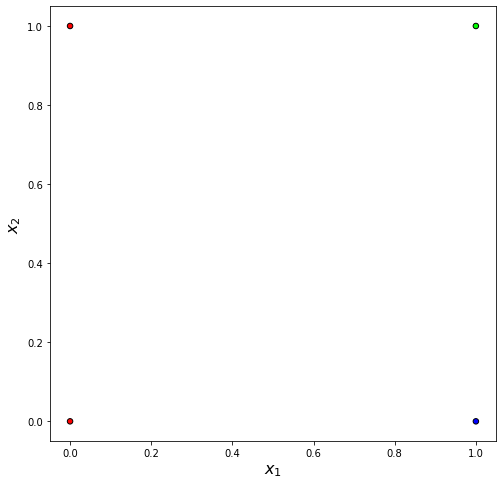

In [129]:
plot_2d_classification_samples(df)

Which label (red/1, green/2, blue/3) will be predicted by the Nearest Neighbor algorithm for the point $x = \pmatrix{1 \\ 0.75}$ ?

Green

### Exercise 5

Consider this new dataset (where `volume (mL)` and `caffeine (g)` are the examples' features and where `drink` is their label):

In [130]:
data = [[250, 0.025, 'tea'],
        [100, 0.01,  'tea'],
        [125, 0.05,  'coffee'],
        [250, 0.1,   'coffee']]

df = pd.DataFrame(data, columns=['volume (mL)', 'caffeine (g)', 'drink'])
df

,volume (mL),caffeine (g),drink
0,250,0.025,tea
1,100,0.010,tea
2,125,0.050,coffee
3,250,0.100,coffee


#### 5.1
Use the Nearest Neighbor method to predict the label of a 100mL drink having 0.075g of caffeine, by intuition, calculation, and / or with some code (up to you, with some justification).

Tea (if we were to plot this on a graph, it would be the closest to the 2 entry)

#### 5.2
What is wrong with this prediction? How to solve this problem?

We didn't standardize the data so the mL will matter much much more than the caffeine content when it comes to making a prediction.

## Nearest Neighbor method with Scikit Learn

Let's play with the Scikit Learn implementation of the Nearest Neighbor algorithm.
The official documentation is there: https://scikit-learn.org/stable/modules/neighbors.html

### Classification

We begin with a "toy" **classification problem**.

Use the `gen_2d_classification_samples()` function (defined above) to generate a dataset.

In [131]:
df = gen_2d_classification_samples(n_samples=20)
df.head()

,x1,x2,y
0,2.058932,0.685875,2
1,-1.272007,-0.761447,1
2,1.000646,6.103651,3
3,-0.211562,6.058631,3
4,6.197135,0.575193,2


Here, examples are defined in $\mathbb{R}^2$ (features are stored in columns `x1` and `x2`).
Examples' labels are defined in the `y` column. This is similar to Exercise 1.

The `y` column contains three possible labels: `1`, `2` and `3` respectively represented by the red, green and blue colors in the following figure.

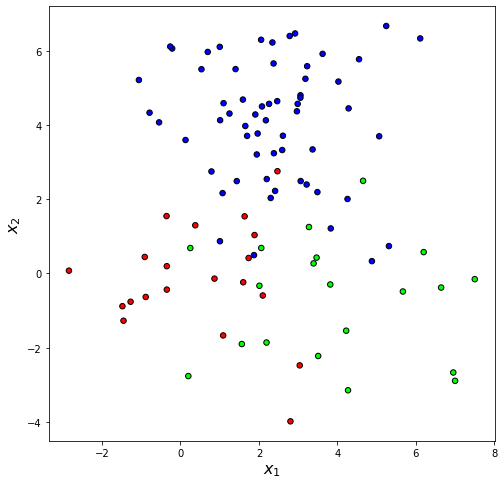

In [132]:
plot_2d_classification_samples(df)

Thus this toy problem is a multiclass classification problem.

Once the dataset is ready, let's make the classifier and train it with the following code:

In [10]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
# 1-NN as a special case of k-NN

In [11]:
model.fit(X=df[['x1', 'x2']].values, y=df['y'])

KNeighborsClassifier(n_neighbors=1)

### Exercise 6

#### 6.1
Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{-2 \\ 0}, x_{p2} = \pmatrix{0 \\ 6}, x_{p3} = \pmatrix{8 \\ 0}$$

Store the result in `model_predictions`.

In [12]:
points = np.array([[-2,0],[0,6],[8,0]])

model_predictions = model.predict(points)
# YOUR CODE HERE

In [137]:
model_predictions

array([1, 3, 2])

#### 6.2
Is the training step (`model.fit()` function) longer to execute than the prediction step (`model.predict()` function)? Why?

*An intuitive answer is expected; you don't have to time any code execution.*

In most cases, the training step (model.fit() function) is longer to execute than the prediction step (model.predict() function).

During the training step, the machine learning model is presented with a set of labeled examples (i.e., training data) and it uses an algorithm to learn the relationship between the input features and the corresponding output labels. This process typically involves a lot of computations, such as matrix multiplications, optimization algorithms, and backpropagation for neural networks. The goal of the training step is to find the best set of parameters (i.e., weights and biases) that minimize the loss function and maximize the model's accuracy on the training data.

In contrast, during the prediction step, the trained model is given new input features (i.e., test data) and it applies the learned relationship to make predictions on the output labels. This step does not involve any further optimization or parameter updates, so it is typically faster than the training step.

Of course, the actual time required for both steps will depend on various factors, such as the size and complexity of the dataset, the type of algorithm used, and the hardware and software environment. However, in general, the training step is expected to take longer than the prediction step, especially for large datasets and complex models.

#### 6.3
The next cell shows the decision boundary of the model. Explain what is a decision boundary in classification.

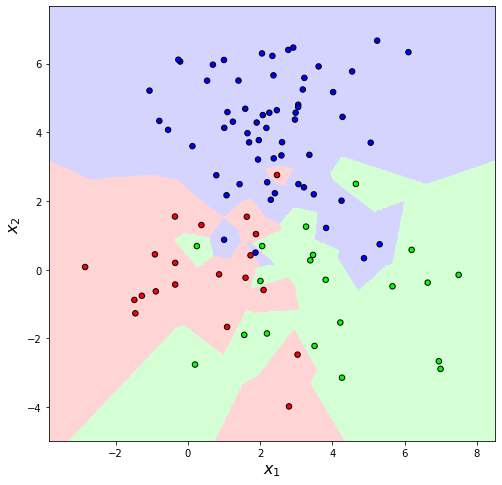

In [138]:
plot_2d_classification_samples(df, model=model)

YOUR ANSWER HERE

#### 6.4
The next cell generates the *Voronoï diagram* of the dataset. The Voronoï diagram makes a partition of the feature space $\mathcal{X}$.
Each partition is a *cell*. What do cells represent?
What does this figure illustrate about the Nearest Neighbor method?

In [ ]:
plot_2d_classification_samples(df, model=model, voronoi=True);

In classification problems, a decision boundary is a dividing line (or surface) that separates the different classes in the feature space. It is the boundary at which the classifier assigns a particular input instance to one class or another.

The decision boundary is determined by the machine learning algorithm during the training process, based on the patterns in the training data. The goal of the algorithm is to learn a decision boundary that maximizes the separation between the different classes, so that it can make accurate predictions on new, unseen data.

### Regression

After the "toy" classification problem, let's work on a toy **regression problem**.

The next cell generates a dataset (where 'x' is the feature and 'y' the label to predict).

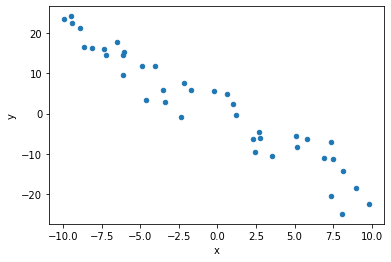

In [145]:
df = gen_and_plot_1d_regression_samples()

Once the dataset is ready, let's make the regressor and train it with the following code:

In [146]:
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1)

In [147]:
model.fit(df[['x']].values, df['y'])

KNeighborsRegressor(n_neighbors=1)

### Exercise 7

#### 7.1
Use the `model.predict()` function to classify the following points:

$$x_{p1} = \pmatrix{-5}, x_{p2} = \pmatrix{0}, x_{p3} = \pmatrix{5}$$

Store it in `model_predictions_bis`.

In [148]:
points = np.array([[-5],[0],[5]])

model_predictions_bis = model.predict(points)

In [150]:
model_predictions_bis

array([11.76707413,  5.5343956 , -5.58313516])

### Plot the model's decision function

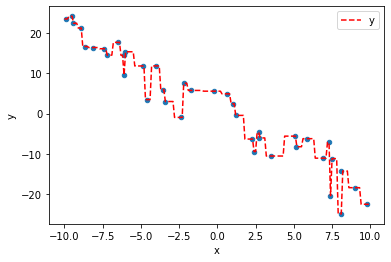

In [149]:
x_pred = np.arange(-10, 10, 0.1).reshape(-1, 1)
y_pred = model.predict(x_pred)

df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

ax = df.plot.scatter(x='x', y='y')
df_pred.plot(x='x', y='y', style='r--', ax=ax);

#### 7.2

Do you think this model *generalizes* well (by generalization, we mean performance on unseen - test - examples drawn from the same distribution as the seen - training - examples; recall what happened with polynomial regression with a high degree)? Why?

No, it is too overfitted; the line adheres too much to the points to something that is going to be slightly off; might be misplaced.

## k-Nearest Neighbors algorithm

The *Nearest Neighbor* method is very sensitive to noise: if an example in $\mathcal{D}$ is wrongly labeled or positioned, all points in its Voronoï cell will be wrong too. The *k Neareast Neighbor* fix this weakness by considering for each prediction the label of several neighbors instead of just one.

Considering a dataset $\mathcal{D}=\{(\boldsymbol{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples and a meta / hyper parameter $k \in \mathbb{N}*$, the *$k$ Nearest Neighbors* model assigns an input vector $\boldsymbol{x}$ to the label $y$ (defined below) of its $k$ closest neighbor in $\mathcal{D}$.
Let's write $\mathcal{N}_k(\boldsymbol{x})$ the set of the $k$ nearest neighbors of $\boldsymbol{x}$ in $\mathcal{D}$.

- For classification problems, the label assigned to $\boldsymbol{x}$ is the **most represented label** among the nearest neighbors (majority vote)
$$f(\boldsymbol{x}) = {\arg\!\max}_c \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} \delta(y_i, c)$$

- For regression problems, the label assigned to $\boldsymbol{x}$ is computed based on the **mean** of the labels of its nearest neighbors $\mathcal{N}_k(\boldsymbol{x})$
$$f(\boldsymbol{x}) = \frac{1}{k} \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} y_i$$

### Exercise 8

We consider the following dataset (where `x1` and `x2` are the example features and where `y` is the example label):

In [48]:
data = [[1, 2, '+'],
        [2, 1, '+'],
        [2, 2, '-'],
        [2, 3, '+'],
        [1, 1, '-'],
        [3, 3, '+']]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,1,2,+
1,2,1,+
2,2,2,-
3,2,3,+
4,1,1,-
5,3,3,+


#### 8.1
Draw this dataset (it is OK to draw it on a sheet of paper: empty the code cell, add a Markdown cell and upload your picture by drag-and-drop; you can also make use of `df.plot`).

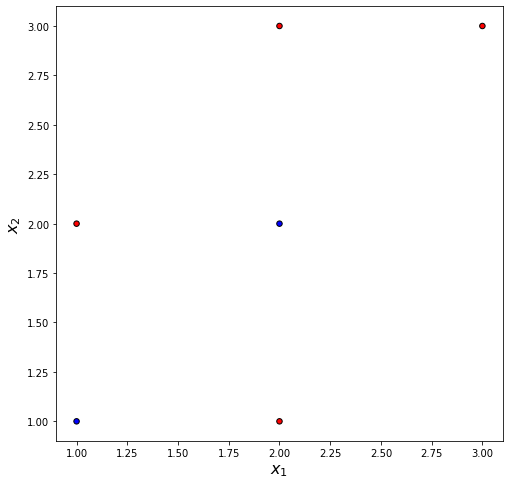

In [49]:
df['y'] = df['y'].map({'+': 1, '-': 2})
plot_2d_classification_samples(df)

#### 8.2
Draw the decision boundary of a Nearest Neighbor model (i.e. 1NN - also OK on a sheet of paper).

You may need to convert `y` to an integer type and make good use of `KNeighborsClassifier` (see Exercise 2).

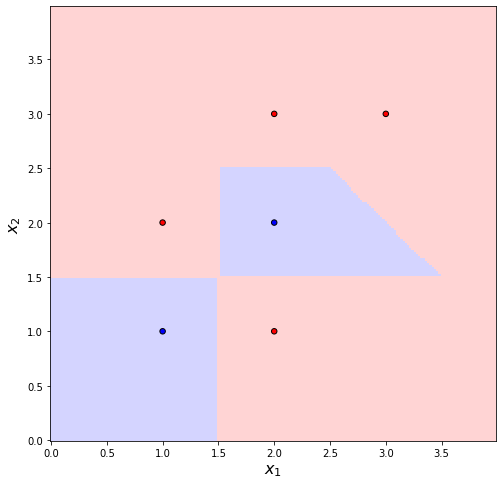

In [18]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
model.fit(X=df[['x1', 'x2']].values, y=df['y'])
plot_2d_classification_samples(df, model=model)

#### 8.3
Draw the decision boundary of a 3 Nearest Neighbor model (i.e. 3NN), either with code or on a sheet of paper.

*Hint:* The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).


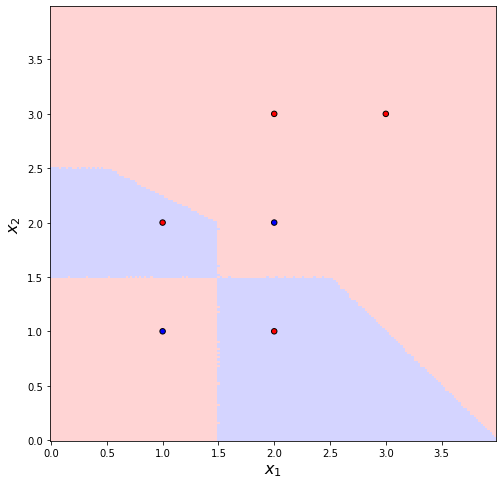

In [20]:
# YOUR CODE HERE
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
model.fit(X=df[['x1', 'x2']].values, y=df['y'])
plot_2d_classification_samples(df, model=model)


#### 8.4
How many errors these two classifiers make on the training dataset (i.e. on the provided points with both values of $k$)?

First classifier makes 0 errors while the second one 4 errors.

#### 8.5
Which label is predicted by these two classifiers for the point $x = \pmatrix{0.5 \\ 2}$?

On the first one plus, on the second one, minus.

## k-Nearest Neighbor (kNN) with Scikit Learn

### Classification

First we regenerate the dataset used throughout Exercise 3.

In [25]:
df = gen_2d_classification_samples()

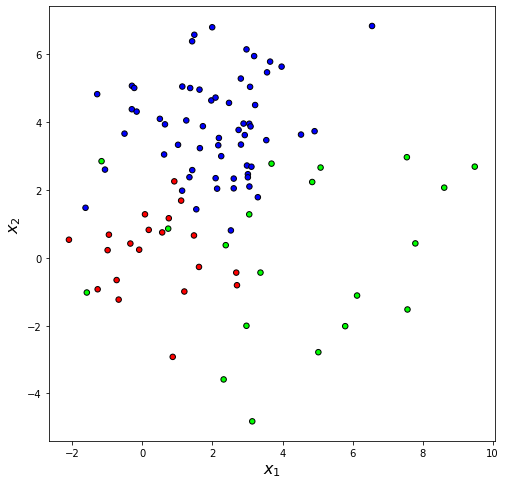

In [26]:
plot_2d_classification_samples(df)

Then we instantiate the classifier, train it and plot the decision boundaries:

In [27]:
def learn_knn_and_plot(**kwargs):
    """
    Learns a knn model and plot the points, their class and the decision boundaries

    :param kwargs: keyword arguments passed to KNeighborsClassifier
    """
    model = sklearn.neighbors.KNeighborsClassifier(**kwargs)
    model.fit(df[['x1', 'x2']].values, df['y'])
    plot_2d_classification_samples(df, model=model)

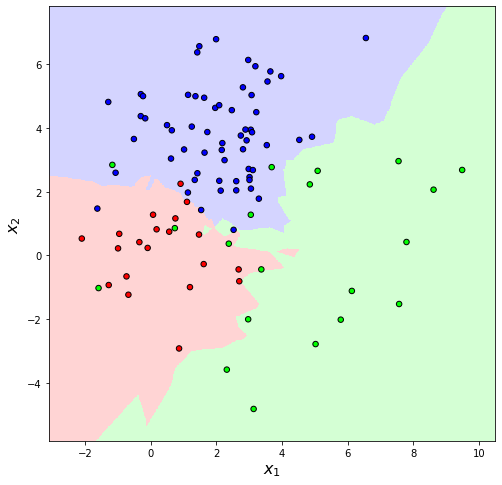

In [28]:
learn_knn_and_plot(n_neighbors=5)

### Exercise 9

#### 9.1
Change the value of the hyperparameter $k$ in the cell above, and observe what happens, i.e. plot the resulting boundaries with the subsequent cell.

What is the influence of the number of neighbors on the boundaries? (Bonus points for the two extreme cases!)

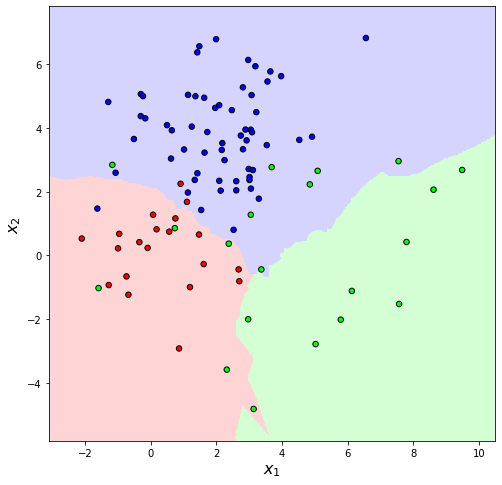

In [31]:
learn_knn_and_plot(n_neighbors=20)

The more neighbours added, the smoother the separation lines are.

#### 9.2
When you face a very noisy dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$ ?

When faced with a very noisy dataset, increasing the value of $k$ in k-Nearest Neighbors (k-NN) algorithm can be a good strategy. This is because increasing the value of $k$ means that the prediction for a new point will be based on the average of more neighbors, rather than just the closest one. This can help to reduce the impact of noisy or mislabeled points, which are more likely to be outliers and therefore less likely to be consistently closest to other points.

However, increasing $k$ too much can also lead to underfitting, where the model is too simple to capture the underlying patterns in the data. Therefore, the choice of $k$ should be based on a balance between reducing noise and maintaining model complexity.



#### 9.3
Is the Voronoi diagram useful for the kNN case (i.e. when $k>1$) ?

When $k>1$, the Voronoi diagram becomes less useful for visualizing the decision boundary of the k-NN classifier.

This is because the Voronoi diagram is based on the concept of nearest neighbors, and the regions in the diagram are defined by the Voronoi cells, which represent the set of points that are closest to each training point. When $k=1$, each Voronoi cell contains only one training point, so the Voronoi diagram can be used to visualize the decision boundary of the k-NN classifier. However, when $k>1$, each Voronoi cell contains multiple training points, and it becomes difficult to visualize how the classifier assigns labels to points in the overlapping regions between cells.

#### 9.4
Plot the decision boundary with $k=2$ and describe what happens in case of equal vote (copy-paste the 3 previous lines of code).

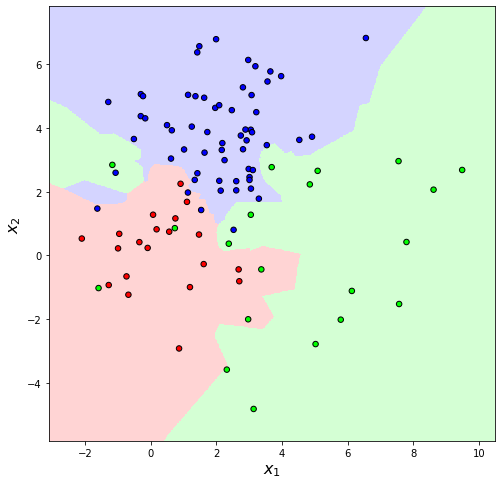

In [33]:
learn_knn_and_plot(n_neighbors=2)

Each of the k nearest neighbors has an equal vote in determining the predicted label, regardless of its distance to the new point. This means that outlier points will have a lesser impact

#### 9.5
Add the `weights = "distance"` parameter in `KNeighborsClassifier`'s constructor. What changes can you observe on the decision boundary? Explain how labels are computed with this new parameter.

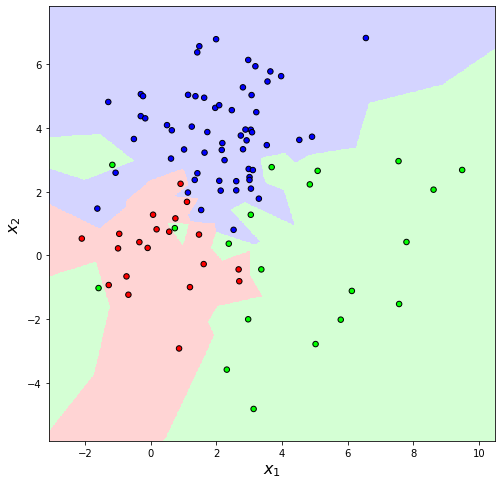

In [34]:
learn_knn_and_plot(n_neighbors=2, weights="distance")

Now, outlier points have a greater impact since we take into account the distance to each of the points.

### Regression

First we regenerate the dataset from Exercise 4 - Regression with 1-NN).

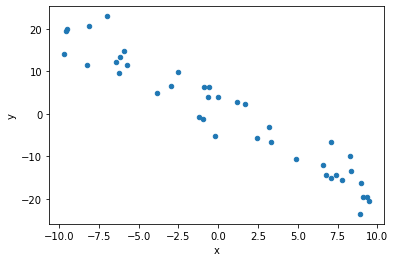

In [38]:
df = gen_and_plot_1d_regression_samples()

Then we instantiate the classifier, train it and plot the decision boundaries:

In [43]:
def train_and_plot_knn_regressor(**kwargs):
    """
    Instantiate, fits a KNN regressor and plots the training points as well as the predictions

    :param kwargs: keyword arguments passed to KNeighborsRegressor constructor
    """
    model = sklearn.neighbors.KNeighborsRegressor(**kwargs)
    model.fit(df[['x']].values, df['y'])

    x_pred = np.arange(-10, 10, 1).reshape(-1, 1)
    y_pred = model.predict(x_pred)

    df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

    ax = df.plot.scatter(x='x', y='y')
    df_pred.plot(x='x', y='y', style='r--', ax=ax);

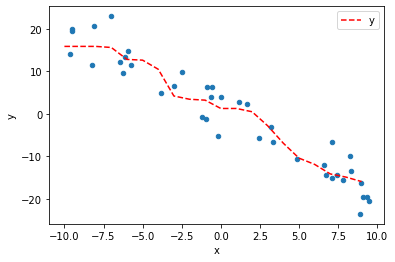

In [47]:
train_and_plot_knn_regressor(n_neighbors=10)

### Exercise 10

*Recall*: The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

#### 10.1
Change the value of this parameter and observe what happens.

What is the influence of the number of neighbors on the decision function (again, bonus points for extreme cases)?

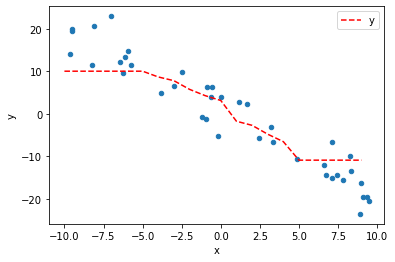

In [42]:
train_and_plot_knn_regressor(n_neighbors=20)

The number of neighbors in k-Nearest Neighbor (k-NN) algorithm has a significant influence on the decision function of the model.

When k is small (e.g., k=1), the decision function of the model will be more complex and will have a higher variance, because the prediction for each data point is based on the label of only one nearest neighbor. This can result in overfitting, where the model is too sensitive to the noise in the data and fails to generalize well to new data.

On the other hand, when k is large (e.g., k=n, where n is the number of training points), the decision function of the model will be simpler and have a lower variance, because the prediction for each data point is based on the average label of all training points. This can result in underfitting, where the model is too simple to capture the underlying patterns in the data and fails to make accurate predictions on both training and test data.

In extreme cases, when k=1, the decision function of the k-NN model will be very sensitive to the noise and outliers in the data, and the model will have high variance and overfitting. When k=n, the decision function of the model will be a constant function, since the prediction for each data point will be based on the average label of all training points, resulting in high bias and underfitting.

Therefore, the choice of the optimal number of neighbors in k-NN algorithm depends on the complexity of the problem and the amount of noise in the data. A common practice is to use cross-validation to estimate the optimal value of k that balances bias and variance, by evaluating the performance of the model on a validation set for different values of k.

#### 10.2
When you face a very noised dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$ ?

When faced with a noisy dataset with wrong labels and misplaced points, increasing the value of k in k-Nearest Neighbor (k-NN) algorithm may help to reduce the impact of the noise and improve the model's performance.